In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import time
import os
import sys
import copy
import time
import datetime
import random
import math
import warnings
warnings.filterwarnings('ignore')

In [3]:
import torch
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
from torch import nn

In [4]:
import matplotlib
# mpl.use('Agg')
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt 
from matplotlib.colors import ListedColormap

matplotlib.rcParams['lines.linewidth'] = 1
matplotlib.rcParams['lines.markersize'] = 5
plt.rcParams['figure.figsize'] = [12, 12]

In [5]:
import numpy as np
import scipy
import seaborn as sns

from tqdm.notebook import tqdm, trange

# Create Pseudo Data

In [6]:
seed = 42
test_size = 0.2

In [7]:
X_var = 1
y_var = 0.01

In [8]:
num_features = 1
num_data = 10000

In [9]:
X = (2*np.random.rand(num_data, num_features)-1)*X_var
y_true = X[:, :1]**2
y_noise = np.random.randn(num_data, num_features)*y_var
y = y_true+y_noise

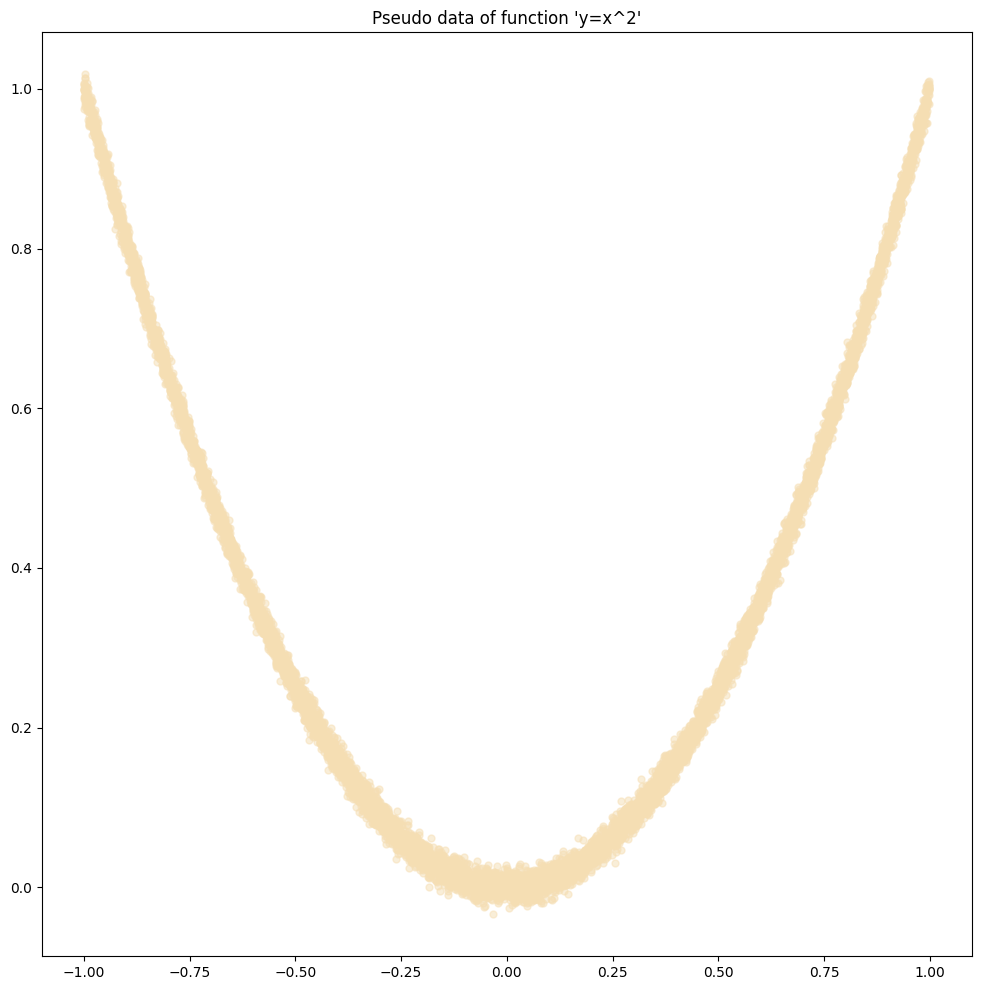

In [10]:
plt.scatter(X, y, c='wheat', alpha=0.5)
plt.title("Pseudo data of function 'y=x^2'")
plt.show()

In [11]:
plt.close()

# Create MLP Regressor to Learn a Proper Function

In [12]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

In [14]:
regr = MLPRegressor(hidden_layer_sizes=(100,100,100), random_state=seed, max_iter=500).fit(X_train, y_train)

In [15]:
y_pred = regr.predict(X_test)
score = regr.score(X_test, y_test)

In [16]:
y_pred = np.expand_dims(y_pred, axis=1)

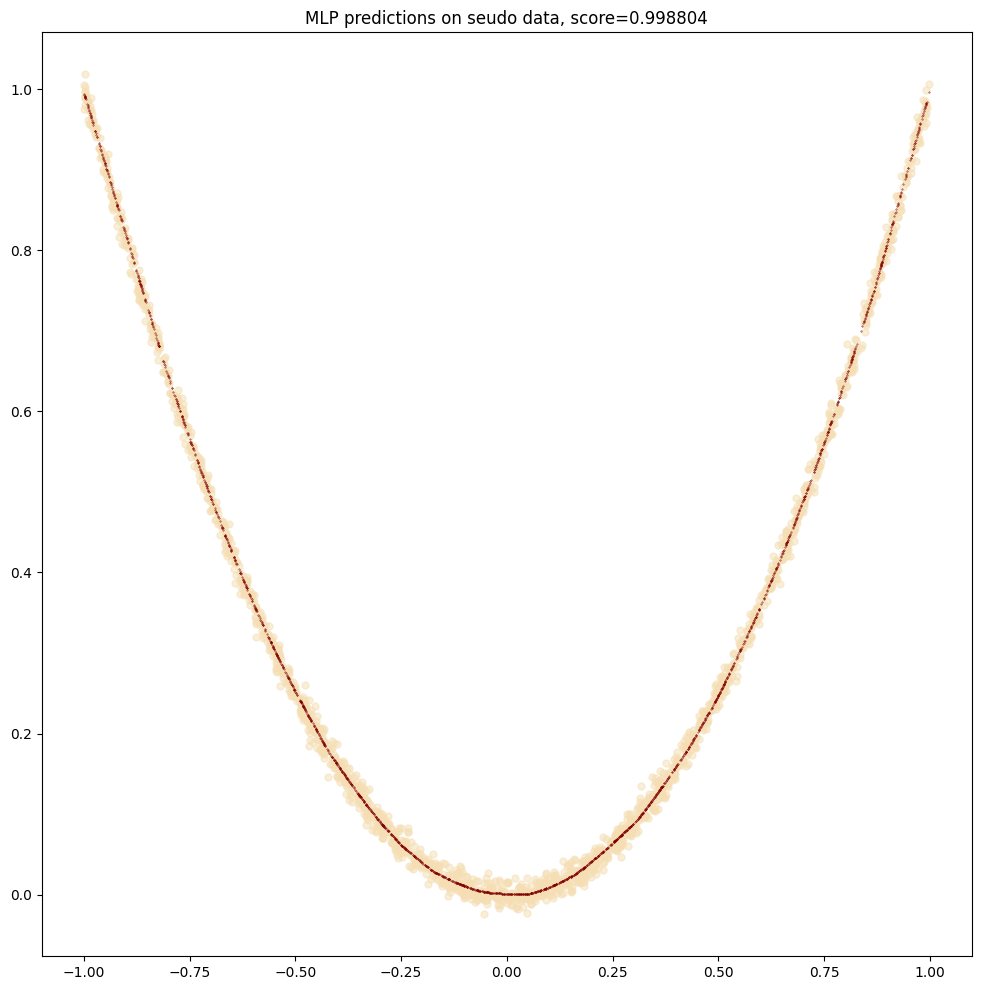

In [17]:
plt.scatter(X_test, y_test, c='wheat', alpha=0.5)
plt.scatter(X_test, y_pred, s=0.1, c='maroon', alpha=1)
plt.title(f"MLP predictions on seudo data, score={score:2f}")
plt.show()

In [18]:
plt.close()

# Learning with different number of noisy features

In [19]:
num_features_options = [1, 26, 51, 76, 101, 126, 151, 176, 201]

In [20]:
figure = plt.figure(figsize=(12, 12))

<Figure size 1200x1200 with 0 Axes>

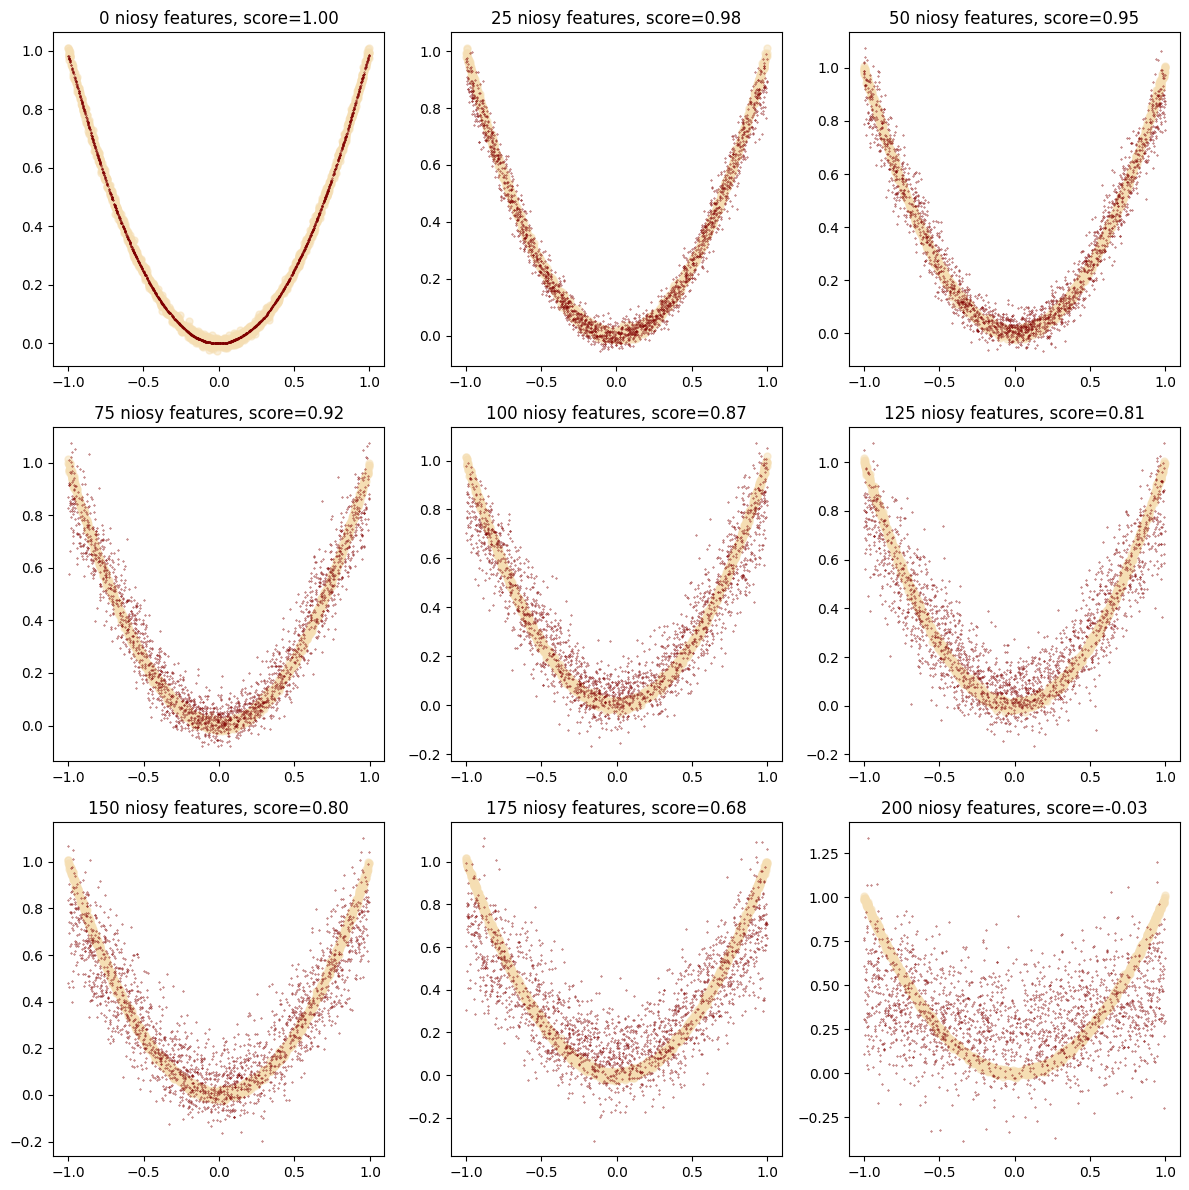

In [21]:
for ids, num_features in enumerate(num_features_options):
    X = (2*np.random.rand(num_data, num_features)-1)*X_var
    y_true = X[:, :1]**2
    y_noise = np.random.randn(num_data, 1)*y_var
    y = y_true+y_noise
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)
    regr = MLPRegressor(hidden_layer_sizes=(100,100,100), random_state=seed, max_iter=500).fit(X_train, y_train)
    
    y_pred = regr.predict(X_test)
    score = regr.score(X_test, y_test)
    y_pred = np.expand_dims(y_pred, axis=1)
    
    ax = plt.subplot(math.ceil(len(num_features_options)/3), 3, ids+1)
    ax.scatter(X_test[:,0], y_test, c='wheat', alpha=0.5)
    ax.scatter(X_test[:,0], y_pred, s=0.1, c='maroon', alpha=1)
    ax.set_title(f"{num_features-1} niosy features, score={score:.2f}")

plt.tight_layout()
plt.savefig("../preliminary.png", dpi=300)
plt.show()